In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

import shap

import matplotlib.pyplot as plt

from utils import query_snowflake

c:\Users\ongch\apps\emirates\skylux-analysis\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Resolution Rate Driver Analysis

A supervised classification model (CatBoost) was built to understand the relative influence of each feature on the target outcome. 

The analysis uses various techniques to pinpoint which features drive resolution rate and how they do so: 

1. Permutation importance to quantify the marginal contribution of each variable
2. SHAP values helped rank the key drivers and show whether each factor increases or decreases the likelihood of the outcome
3. Partial Dependence plot to visualize how changes in each feature shift the predicted probability of the outcome

This multi-method approach provides a stable driver identification even with mixed-type features, non-linear relationships, and interactions.

In [19]:
TARGET_COL = "RESOLVED_IND"
CATEGORICAL_FEATURES = ["CHANNEL", "QUEUE", "EMPLOYMENT_TYPE", "COMPLETED_L1", "COMPLETED_L2", "COMPLETED_L3"]

df = query_snowflake("select * from ea_insights_assessment.ea_insights_schema.interactions_vw")
cols_to_include = [
    "CHANNEL", "QUEUE", "EMPLOYMENT_TYPE", "COMPLETED_L1", "COMPLETED_L2", "COMPLETED_L3", 
    "INTERACTION_DURATION", "POST_CALL_HANDLE_DURATION", "WAIT_TIME", "TENURE_MONTHS",
    "RESOLVED_IND"
]
df = df[cols_to_include]

# Separate X, y
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

# Ensure target is 0/1 for binary classification
if y.dtype == "object":
    y = y.astype("category").cat.codes  # maps classes to 0,1,...

# Map categorical feature names to indices for CatBoost
cat_feature_indices = [X.columns.get_loc(c) for c in CATEGORICAL_FEATURES]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [20]:
train_pool = Pool(X_train, y_train, cat_features=cat_feature_indices)
test_pool = Pool(X_test, y_test, cat_features=cat_feature_indices)

model = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    depth=6,
    learning_rate=0.05,
    iterations=500,
    random_seed=42,
    verbose=50,
)

model.fit(train_pool, eval_set=test_pool, use_best_model=True)

0:	test: 0.7262520	best: 0.7262520 (0)	total: 103ms	remaining: 51.4s
50:	test: 0.7374839	best: 0.7376038 (42)	total: 6.46s	remaining: 56.9s
100:	test: 0.7378647	best: 0.7378694 (99)	total: 12.4s	remaining: 49.1s
150:	test: 0.7379129	best: 0.7379805 (123)	total: 17.8s	remaining: 41.2s
200:	test: 0.7378684	best: 0.7379805 (123)	total: 23.1s	remaining: 34.3s
250:	test: 0.7376670	best: 0.7379805 (123)	total: 28.8s	remaining: 28.6s
300:	test: 0.7374881	best: 0.7379805 (123)	total: 34.7s	remaining: 23s
350:	test: 0.7371388	best: 0.7379805 (123)	total: 41.1s	remaining: 17.4s
400:	test: 0.7366260	best: 0.7379805 (123)	total: 47.2s	remaining: 11.7s
450:	test: 0.7364115	best: 0.7379805 (123)	total: 54.4s	remaining: 5.91s
499:	test: 0.7359943	best: 0.7379805 (123)	total: 1m 1s	remaining: 0us

bestTest = 0.7379804788
bestIteration = 123

Shrink model to first 124 iterations.


In [21]:
y_pred_proba = model.predict_proba(test_pool)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

print("Test ROC-AUC:", roc_auc_score(y_test, y_pred_proba))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))

Test ROC-AUC: 0.7379804788038938

Classification report:

              precision    recall  f1-score   support

       False       0.62      0.44      0.51      5654
        True       0.74      0.86      0.79     10546

    accuracy                           0.71     16200
   macro avg       0.68      0.65      0.65     16200
weighted avg       0.70      0.71      0.69     16200



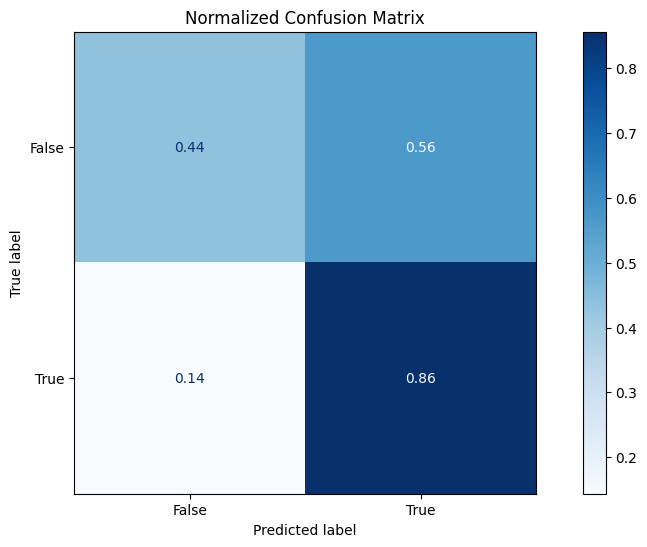

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(12, 6))

disp_norm = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    cmap="Blues",
    normalize="true",
    ax=ax
)

ax.set_title("Normalized Confusion Matrix")
plt.show()

In [23]:
cb_importance = model.get_feature_importance(train_pool, type="PredictionValuesChange")
feat_imp_cb = pd.DataFrame({
    "feature": X.columns,
    "cb_importance": cb_importance
}).sort_values("cb_importance", ascending=False)

feat_imp_cb

,feature,cb_importance
9,TENURE_MONTHS,71.441594
6,INTERACTION_DURATION,11.304155
4,COMPLETED_L2,10.635590
0,CHANNEL,2.299614
8,WAIT_TIME,1.169739
3,COMPLETED_L1,1.037527
5,COMPLETED_L3,0.927174
7,POST_CALL_HANDLE_DURATION,0.633905
2,EMPLOYMENT_TYPE,0.297445
1,QUEUE,0.253259


In [24]:
from sklearn.metrics import make_scorer

# Use ROC-AUC as scoring
scorer = "roc_auc"

pi_result = permutation_importance(
    model,
    X_test,
    y_test,
    n_repeats=20,
    random_state=42,
    scoring=scorer,
)

feat_imp_pi = pd.DataFrame({
    "feature": X_test.columns,
    "pi_importance_mean": pi_result.importances_mean,
    "pi_importance_std": pi_result.importances_std,
}).sort_values("pi_importance_mean", ascending=False)

feat_imp_pi

,feature,pi_importance_mean,pi_importance_std
9,TENURE_MONTHS,0.190603,0.004001
6,INTERACTION_DURATION,0.021185,0.001125
4,COMPLETED_L2,0.013195,0.000958
0,CHANNEL,0.003278,0.000542
3,COMPLETED_L1,0.000362,0.000250
8,WAIT_TIME,0.000286,0.000193
7,POST_CALL_HANDLE_DURATION,0.000142,0.000081
1,QUEUE,0.000108,0.000035
2,EMPLOYMENT_TYPE,-0.000009,0.000032
5,COMPLETED_L3,-0.000108,0.000105


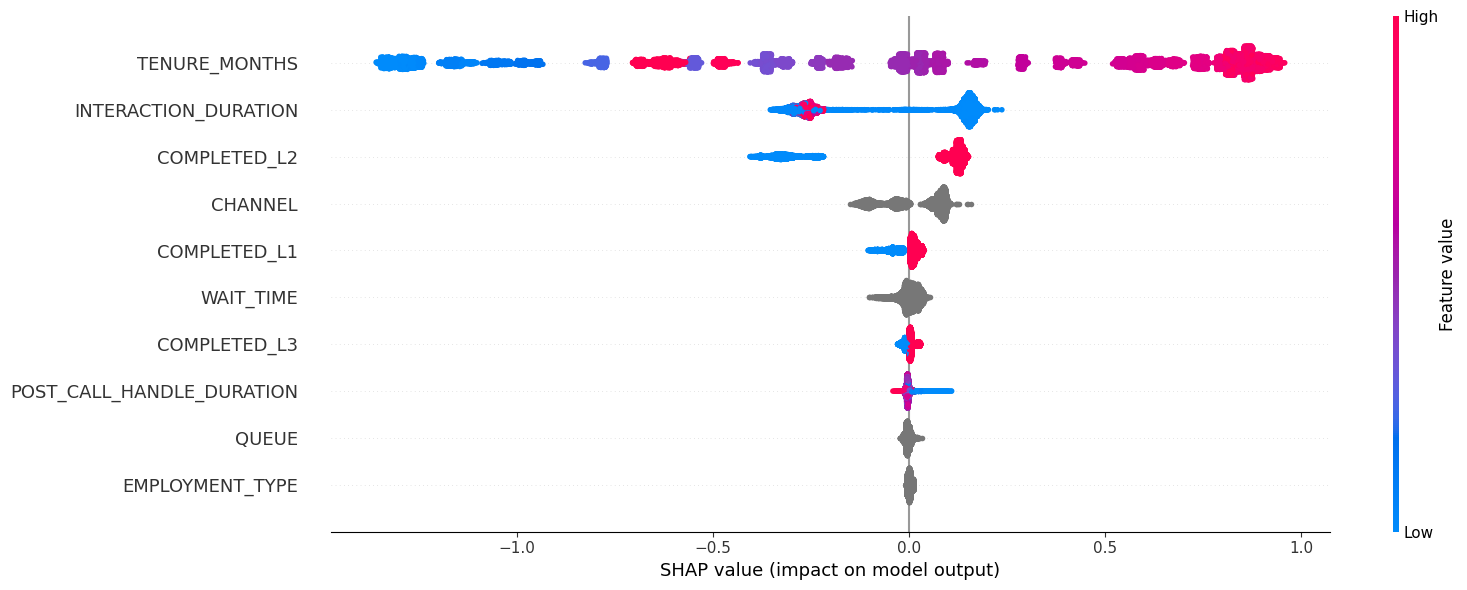

In [25]:
X_shap = X_test.copy()
pool_shap = Pool(X_shap, cat_features=cat_feature_indices)

shap_values = model.get_feature_importance(
    pool_shap, 
    type="ShapValues"
)

# For binary classification, last column is base value; others are feature SHAPs
# shap_values shape: (n_samples, n_features + 1)
shap_values_feat = shap_values[:, :-1]  # drop bias term
expected_value = shap_values[:, -1].mean()

explainer = shap.TreeExplainer(model)

# Global summary (beeswarm)
shap.summary_plot(
    shap_values_feat,
    X_shap,
    plot_size=(16, 6),
    show=True
)

In [26]:
mean_abs_shap = np.abs(shap_values_feat).mean(axis=0)

feat_imp_shap = pd.DataFrame({
    "feature": X_shap.columns,
    "mean_abs_shap": mean_abs_shap
}).sort_values("mean_abs_shap", ascending=False)

feat_imp_shap

,feature,mean_abs_shap
9,TENURE_MONTHS,0.631459
6,INTERACTION_DURATION,0.199343
4,COMPLETED_L2,0.173433
0,CHANNEL,0.071267
3,COMPLETED_L1,0.022198
8,WAIT_TIME,0.015550
5,COMPLETED_L3,0.007065
7,POST_CALL_HANDLE_DURATION,0.006936
1,QUEUE,0.005629
2,EMPLOYMENT_TYPE,0.003303


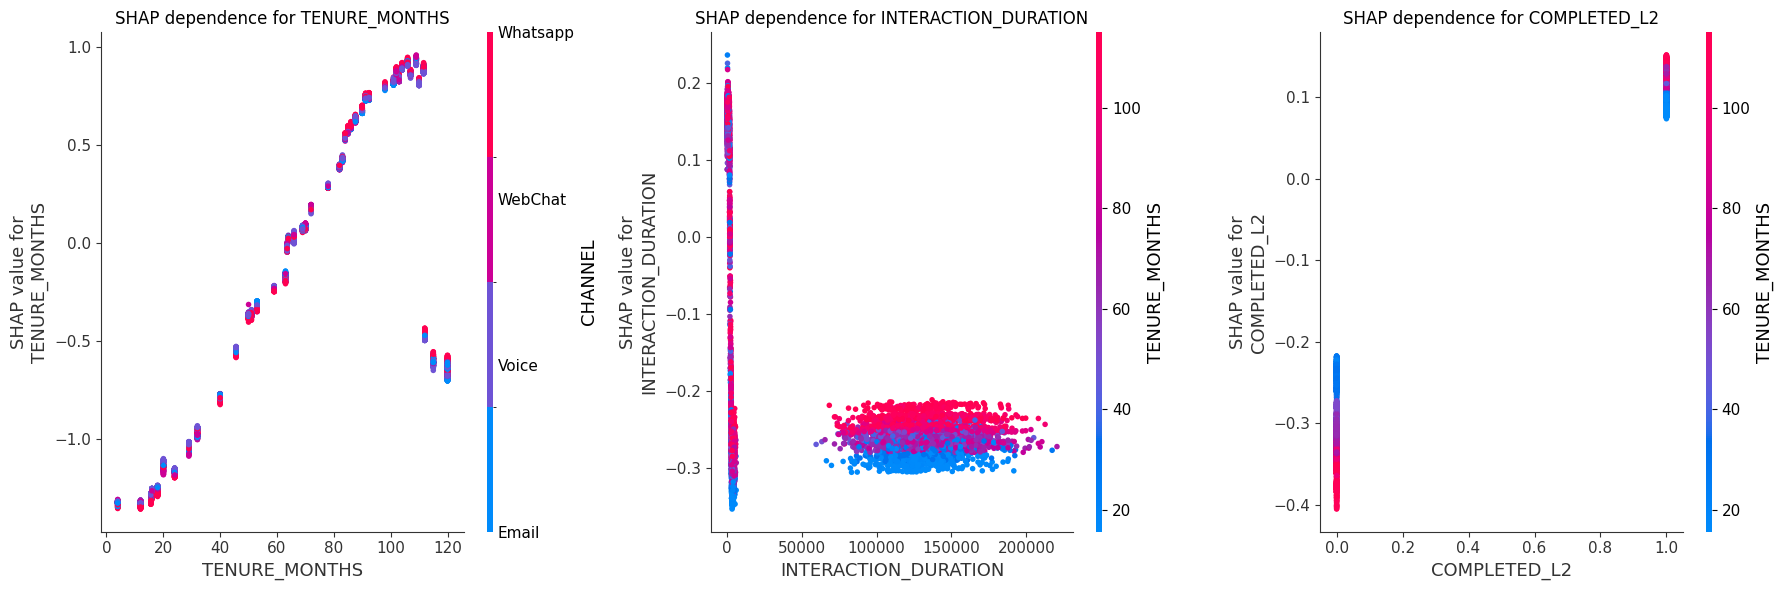

In [27]:
top_features = feat_imp_shap["feature"].head(3).tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

for ax, f in zip(axes, top_features):
    shap.dependence_plot(
        f,
        shap_values_feat,
        X_shap,
        ax=ax,
        show=False   # important: disable auto-show so we can control layout
    )
    ax.set_title(f"SHAP dependence for {f}")

plt.tight_layout()
plt.show()

c:\Users\ongch\apps\emirates\skylux-analysis\.venv\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 6 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


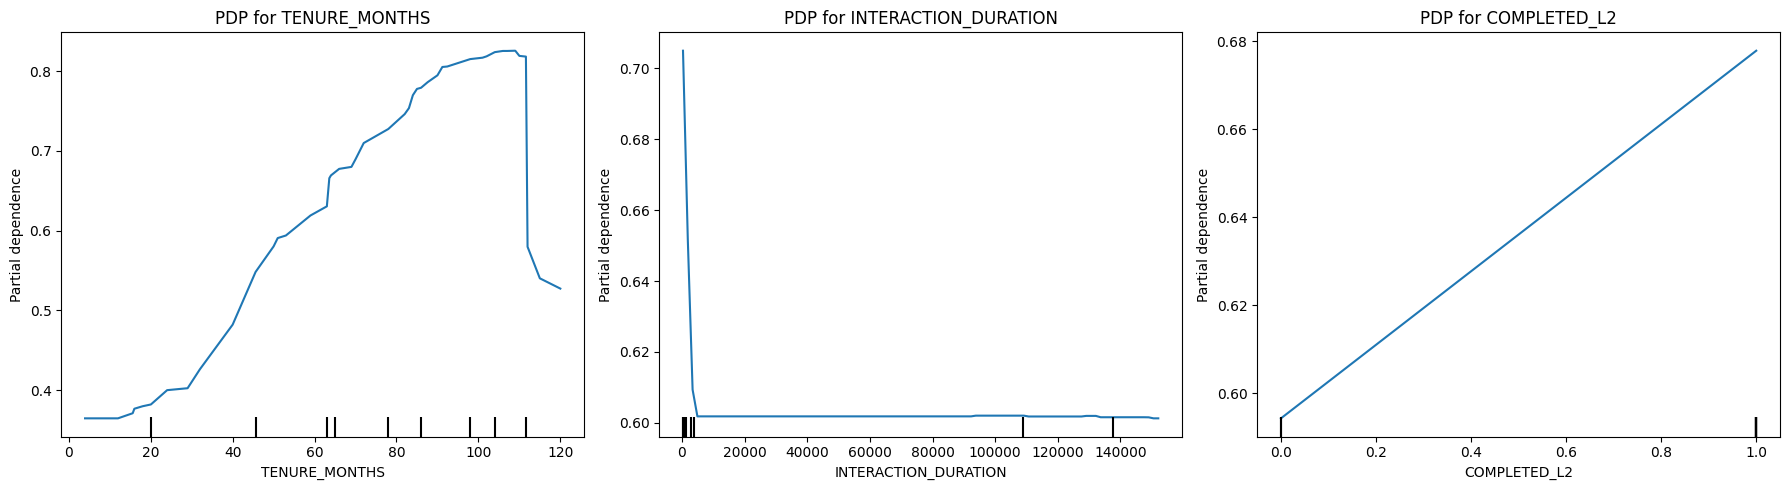

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

for ax, f in zip(axes, top_features):
    PartialDependenceDisplay.from_estimator(
        model,
        X_test,
        [f],
        kind="average",
        ax=ax
    )
    ax.set_title(f"PDP for {f}")

plt.tight_layout()
plt.show()

In [29]:
seeds = [0, 1, 2, 3, 4]
all_runs = []

for rs in seeds:
    model_tmp = CatBoostClassifier(
        loss_function="Logloss",
        depth=6,
        learning_rate=0.05,
        iterations=300,
        random_seed=rs,
        verbose=False,
    )
    model_tmp.fit(train_pool, eval_set=test_pool, use_best_model=False)
    
    shap_vals_tmp = model_tmp.get_feature_importance(
        pool_shap,
        type="ShapValues"
    )[:, :-1]
    
    mean_abs_shap_tmp = np.abs(shap_vals_tmp).mean(axis=0)
    
    run_df = pd.DataFrame({
        "feature": X_shap.columns,
        "mean_abs_shap": mean_abs_shap_tmp,
        "seed": rs
    })
    all_runs.append(run_df)

stability_df = pd.concat(all_runs)

# Compute mean & std of importance across seeds
stability_summary = (
    stability_df
    .groupby("feature")["mean_abs_shap"]
    .agg(["mean", "std"])
    .sort_values("mean", ascending=False)
)

stability_summary

,mean,std
feature,,
TENURE_MONTHS,0.655791,0.006943
COMPLETED_L2,0.184103,0.004389
INTERACTION_DURATION,0.175298,0.023333
CHANNEL,0.100431,0.022369
COMPLETED_L1,0.034334,0.002505
WAIT_TIME,0.026499,0.004309
POST_CALL_HANDLE_DURATION,0.016732,0.000278
QUEUE,0.011962,0.001801
COMPLETED_L3,0.010511,0.002430
